In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import imagehash
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.applications import VGG16
from keras.applications import ResNet101

In [9]:
train_path = '/kaggle/input/terrain-recognition/Data Main/train'
test_path = '/kaggle/input/terrain-recognition/Data Main/test'

In [10]:
from keras.preprocessing.image import ImageDataGenerator
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [11]:
size_images = 150
batch_size = 32

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = batch_size,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

Found 31571 images belonging to 4 classes.


In [13]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [14]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 6769 images belonging to 4 classes.


In [15]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

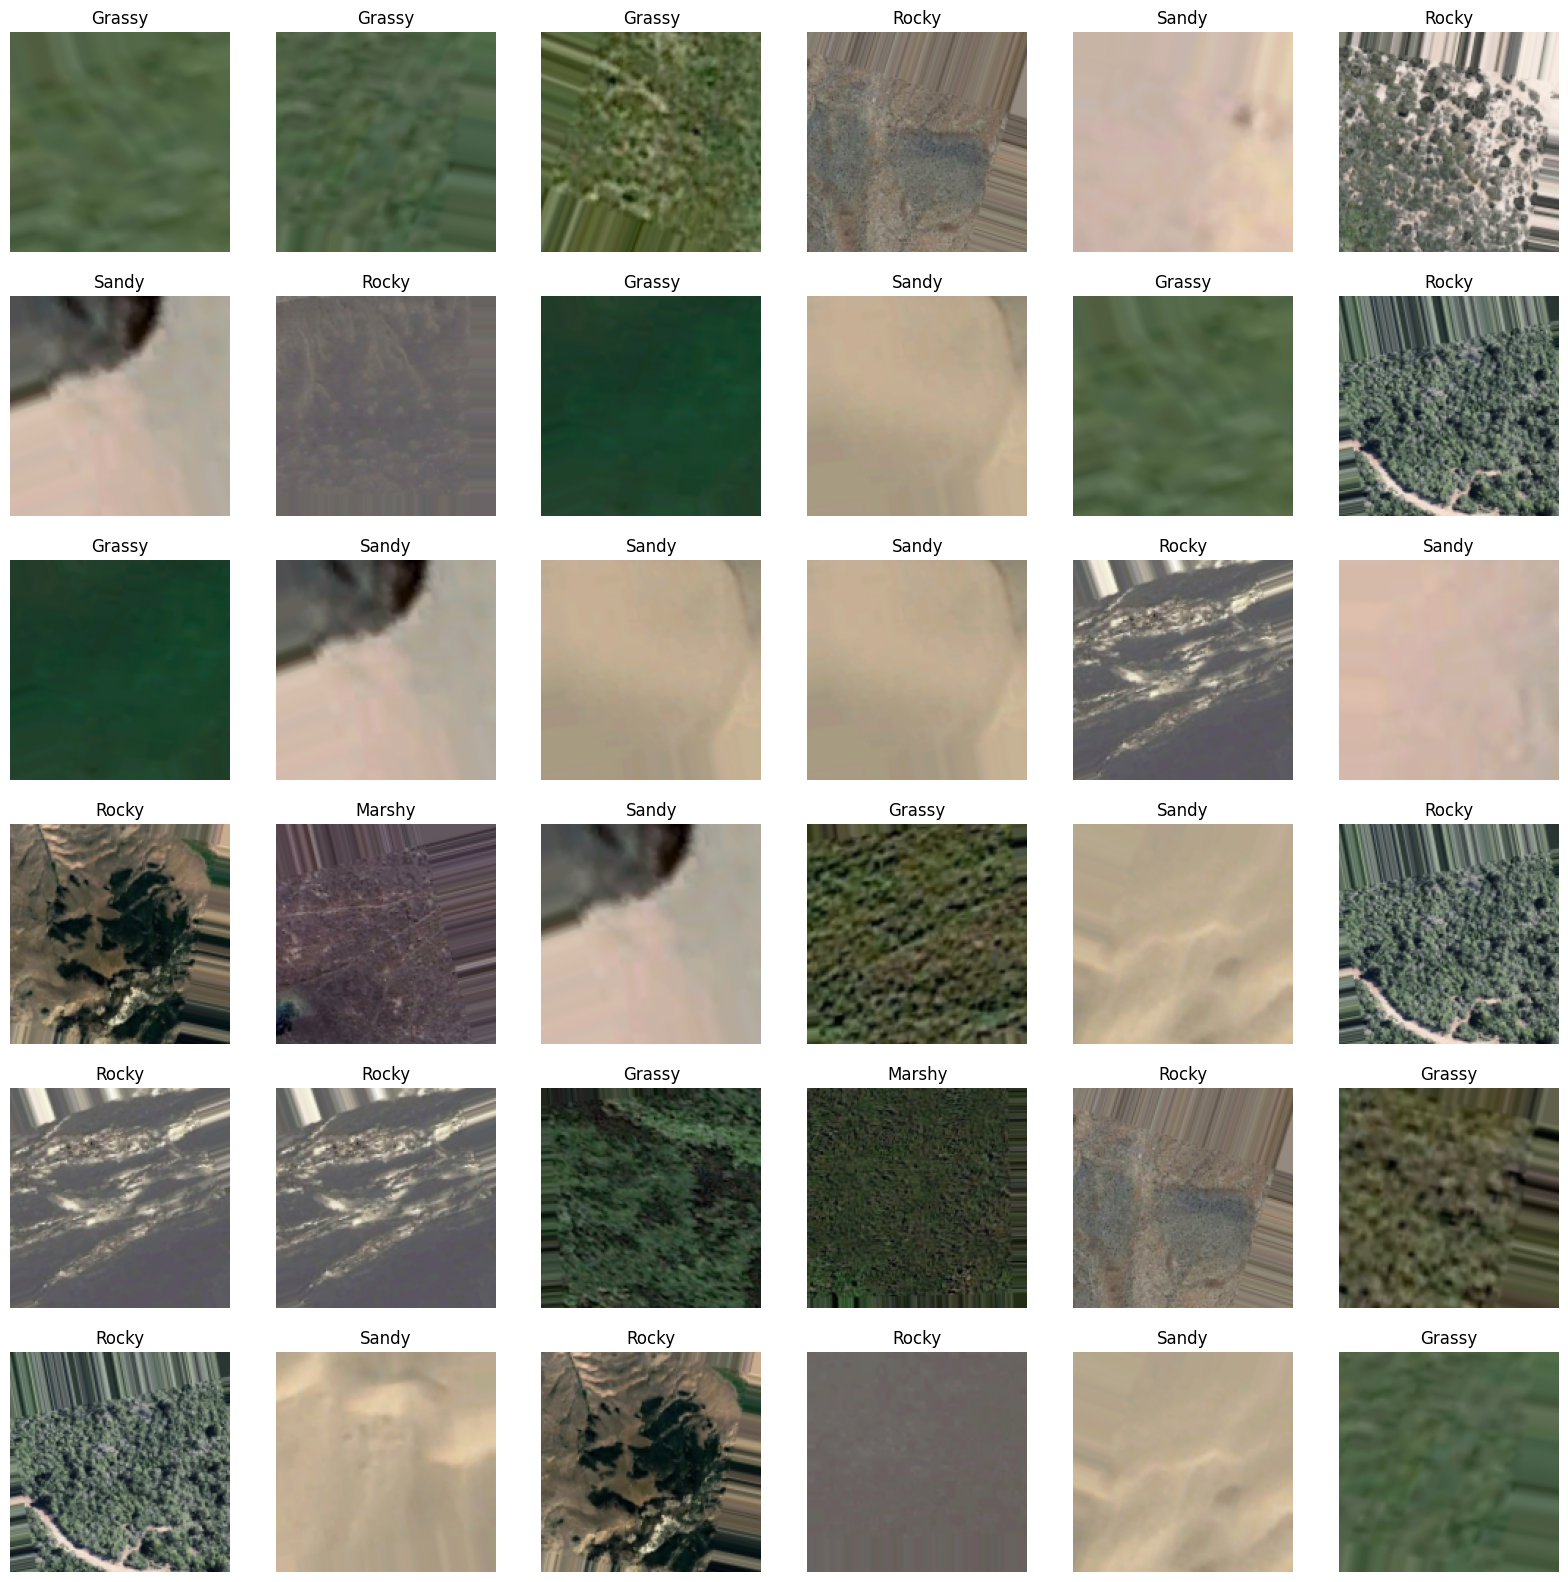

In [16]:
Show_Images(train_generator)

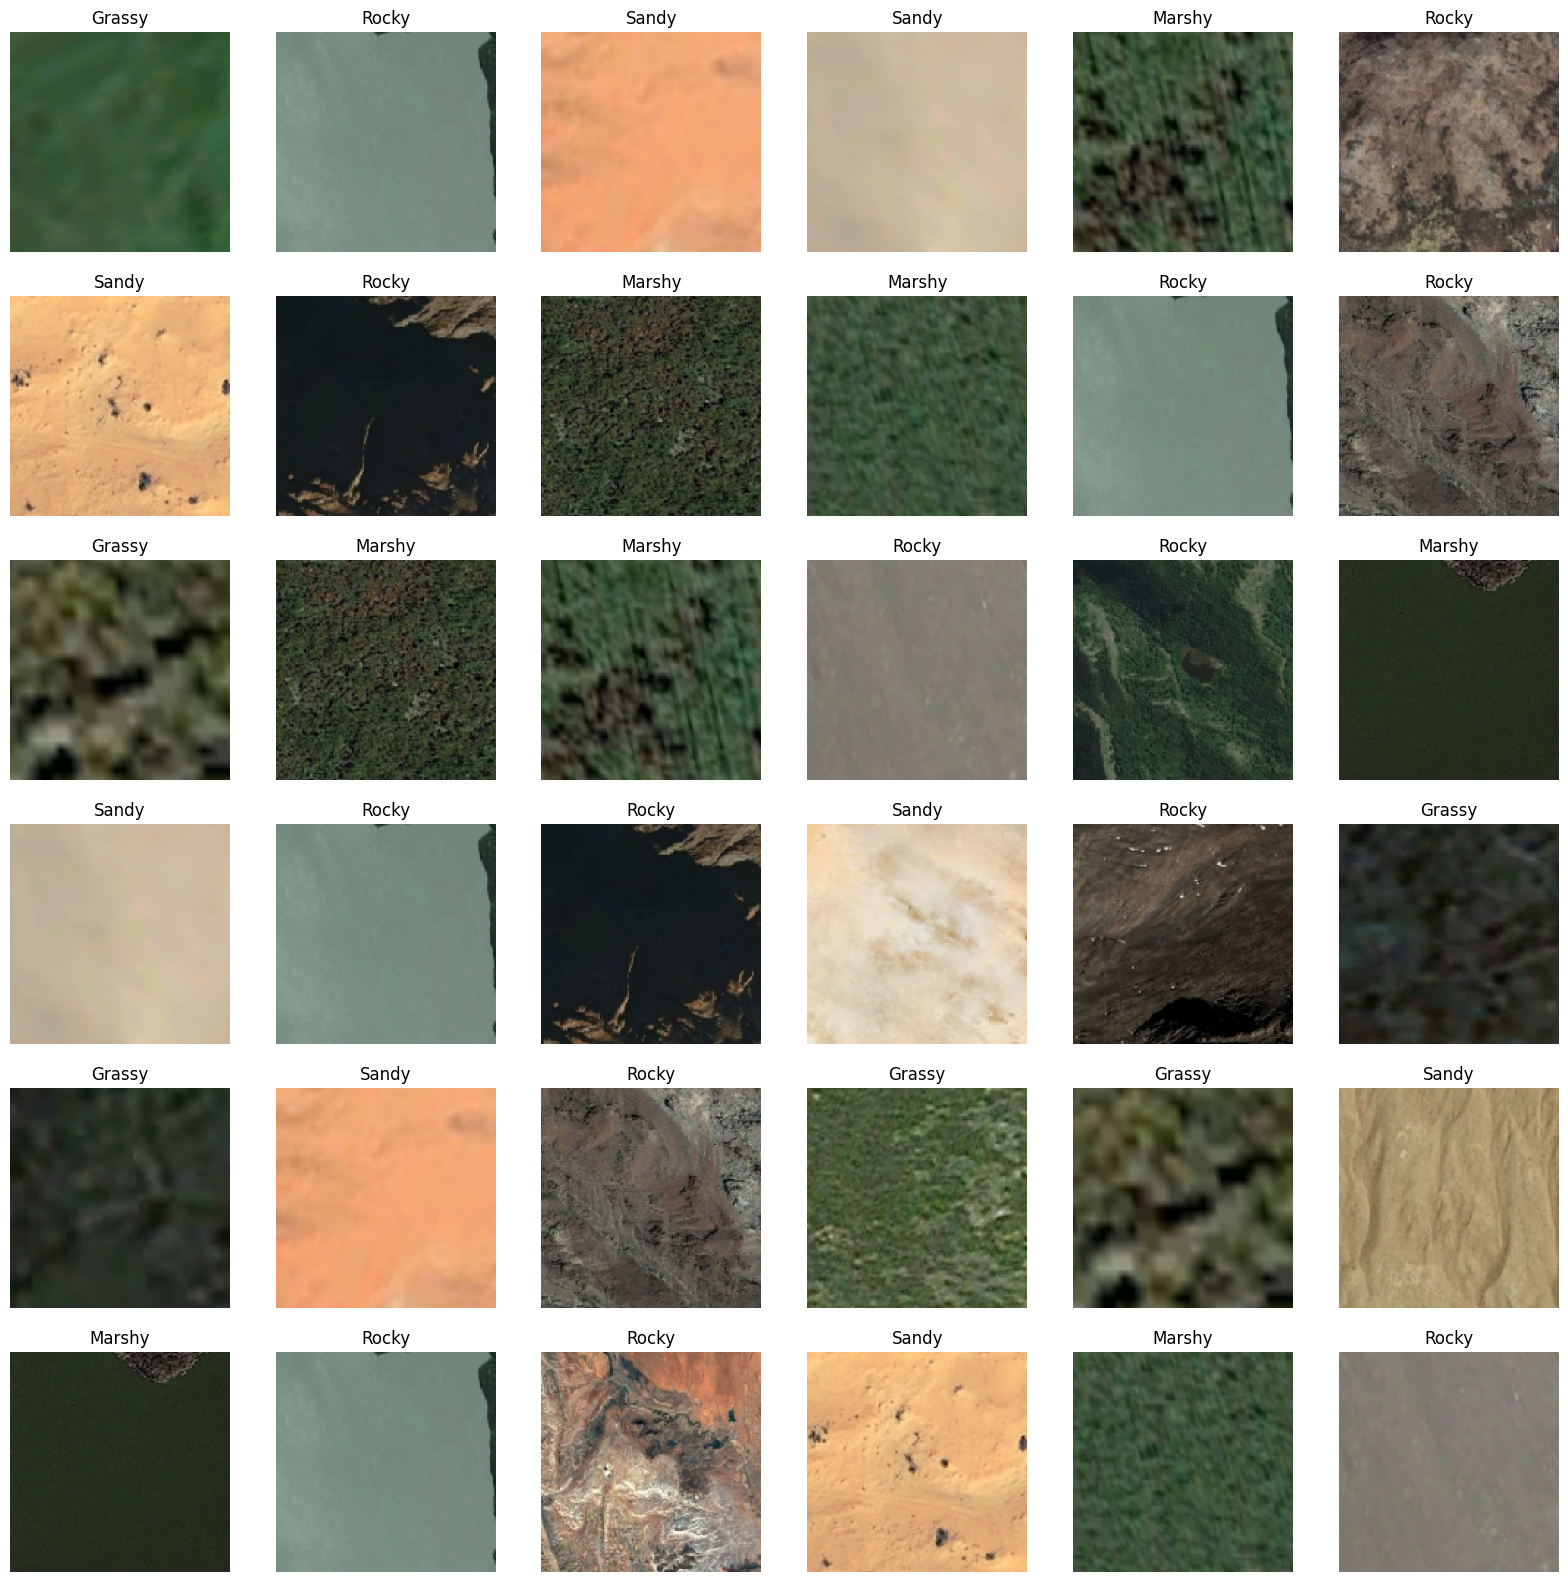

In [17]:
Show_Images(test_generator)

In [18]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [19]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [20]:
# Load the VGG16 model without the fully connected layers (include_top=False)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [21]:
# Freeze the layers of the base model

for layer in base_model.layers:
    layer.trainable = False

In [22]:
from tensorflow.keras import layers
model = tf.keras.models.Sequential([
    base_model,
    
    layers.Flatten(),
    
    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6,activation='softmax'),
])

In [23]:
# Define the parameters for the exponential decay schedule
initial_learning_rate = 0.1     # Initial learning rate
decay_steps = 1000              # Number of steps before decaying the learning rate
decay_rate = 0.5                # Rate at which the learning rate decays
staircase = True                # Whether to use staircase decay (integer division of step by decay_steps)

# Create the exponential decay schedule
def lr_schedule(epoch, lr):
    if staircase:
        return lr * decay_rate ** (epoch // decay_steps)
    else:
        return lr * decay_rate ** (epoch / decay_steps)

In [24]:

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [25]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [26]:
from keras.callbacks import LearningRateScheduler

lr_callback = LearningRateScheduler(lr_schedule)
callback=[early_stopping , learning_rate_reduce , lr_callback]

In [27]:
model.compile(optimizer=keras.optimizers.Adam(lr=lr_callback),
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [28]:

from tensorflow.keras.layers import Dense

# Get the model architecture up to the last layer
model = tf.keras.Sequential(model.layers[:-1])

# Add a new output layer for 4 classes
new_output = Dense(4, activation='softmax')  # Assuming 4 classes
model.add(new_output)  # Add the new output layer

# Compile the model again after modifying the architecture
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [29]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
)

Epoch 1/20
986/986 [==============================] - 378s 378ms/step - loss: 0.4502 - accuracy: 0.8350 - val_loss: 0.2440 - val_accuracy: 0.9148 - lr: 0.0010
Epoch 2/20
986/986 [==============================] - 270s 274ms/step - loss: 0.3166 - accuracy: 0.8932 - val_loss: 0.2437 - val_accuracy: 0.9113 - lr: 0.0010
Epoch 3/20
986/986 [==============================] - 269s 273ms/step - loss: 0.2828 - accuracy: 0.9051 - val_loss: 0.1833 - val_accuracy: 0.9334 - lr: 0.0010
Epoch 4/20
986/986 [==============================] - 270s 274ms/step - loss: 0.2308 - accuracy: 0.9217 - val_loss: 0.2059 - val_accuracy: 0.9242 - lr: 0.0010
Epoch 5/20
986/986 [==============================] - 275s 279ms/step - loss: 0.2148 - accuracy: 0.9268 - val_loss: 0.1767 - val_accuracy: 0.9335 - lr: 0.0010
Epoch 6/20
986/986 [==============================] - 272s 275ms/step - loss: 0.2081 - accuracy: 0.9322 - val_loss: 0.1923 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 7/20
986/986 [==========================

In [30]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12722167372703552
Test accuracy: 0.9546461701393127


<Figure size 640x480 with 0 Axes>

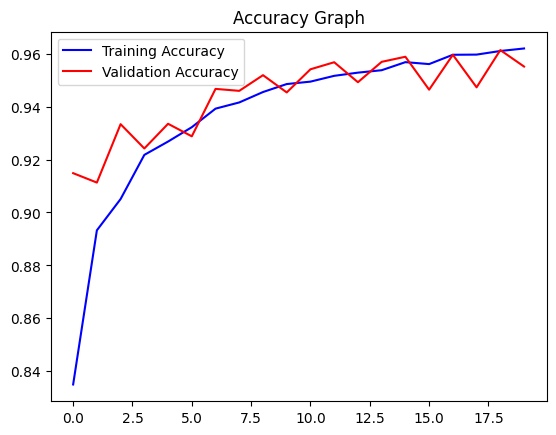

<Figure size 640x480 with 0 Axes>

In [31]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

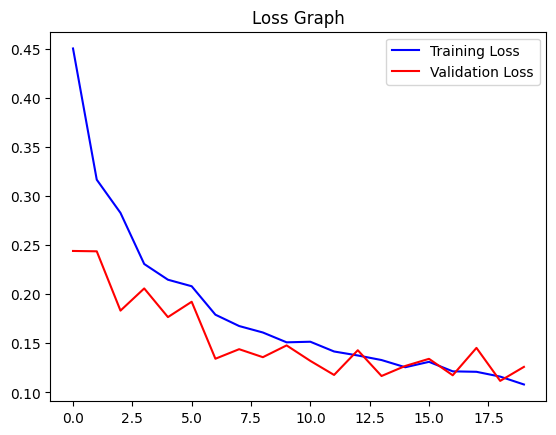

In [32]:
# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()